In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from keras.models import Model,Sequential
from keras.layers import  LSTM
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression,Lasso,Ridge,ElasticNet,HuberRegressor,Lars,LassoLars,
                                  PassiveAggressiveRegressor,RANSACRegressor,SGDRegressor)
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import  mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import itertools

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [3]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [4]:
df.sort_values('Date',inplace=True)

In [5]:
df.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
138707,Materials,2260,Sahara Petrochemical Co.,2009-01-03,12.15,12.90,12.10,12.85,0.80,6.63,2617351,32610608.60,989
237007,Retailing,4050,Saudi Automotive Services Co.,2009-01-03,11.75,12.15,11.75,12.05,0.50,4.32,2767819,33195157.05,1206
73500,Materials,2020,Saudi Arabian Fertilizer Co.,2009-01-03,92.00,98.50,92.00,98.50,8.75,9.74,871456,84833829.25,999
407889,Insurance,8180,Al Sagr Cooperative Insurance Co.,2009-01-03,12.15,13.25,12.15,13.25,1.15,9.50,2091187,26429787.35,1209


In [6]:
df['Company Name'].groupby(df['Industry Group']).value_counts()

Industry Group  Company Name                           
Banks           Al Rajhi Bank                              2722
                Alinma Bank                                2722
                Arab National Bank                         2722
                Bank Albilad                               2722
                Bank Aljazira                              2722
                                                           ... 
Transportation  Saudi Public Transport Co.                 2722
                United International Transportation Co.    2722
                Saudi Ground Services Co.                  1102
Utilities       National Gas and Industrialization Co.     2722
                Saudi Electricity Co.                      2722
Name: Company Name, Length: 205, dtype: int64

In [7]:
Saudi_Ceramic = df[df['Company Name']== 'Saudi Ceramic Co.']

In [8]:
Saudi_Ceramic_for_model = Saudi_Ceramic[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [9]:
Saudi_Ceramic_for_model.head(4)

,Date,Open,High,Low,Close,Change,% Change
78944,2009-01-03,108.00,112.25,107.00,110.50,4.00,3.75
78951,2009-01-04,111.75,112.50,109.00,109.00,-1.50,-1.35
78952,2009-01-05,110.00,111.25,107.75,109.25,0.25,0.22
78950,2009-01-06,110.00,112.00,109.00,111.50,2.25,2.05


In [10]:
Saudi_Ceramic_for_model.reset_index(inplace=True)

In [11]:

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(Saudi_Ceramic_for_model["Date"][-(227):])[0]

In [12]:
split_date

Timestamp('2019-01-01 00:00:00')

In [13]:
Saudi_Ceramic_for_arima = Saudi_Ceramic_for_model[['Date', 'Open', 'High', 'Low', 'Close', 'Change', '% Change']]

In [14]:
Saudi_Ceramic_for_arima.set_index('Date',inplace=True)

In [15]:
training_set, test_set = Saudi_Ceramic_for_model[Saudi_Ceramic_for_model['Date'] < split_date], Saudi_Ceramic_for_model[Saudi_Ceramic_for_model['Date'] >= split_date]


In [16]:
training_set.shape

(2495, 8)

In [17]:
test_set.shape

(227, 8)

In [18]:
test_set.set_index('Date',inplace=True)

In [19]:
training_set.set_index('Date',inplace=True)

In [20]:
training_set = training_set.drop(['index'], 1)
test_set = test_set.drop(['index'], 1)

In [21]:
training = training_set.values

In [22]:
testing = test_set.values

## LSTM

## Window length

In [23]:
window_len = 5

LSTM_training_inputs = []
for i in range(len(training)-window_len):
    temp_set = training[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = training_set['Close'][window_len:].values
LSTM_training_inputs = np.array(LSTM_training_inputs)


#Create windows for testing
LSTM_test_inputs = []
for i in range(len(testing)-window_len):
    temp_set1 = testing[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set1)
LSTM_test_outputs = test_set['Close'][window_len:].values
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [24]:
LSTM_test_inputs.shape

(222, 5, 6)

In [25]:
LSTM_training_inputs.shape

(2490, 5, 6)

In [26]:
# If you want to reste the model 
# nn_model.reset_states()
# nn_model.reset_metrics()

In [27]:
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [28]:

nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 400)

nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=120, batch_size=160, verbose=1,validation_split= 0.2)

Train on 1992 samples, validate on 498 samples
Epoch 1/120
1992/1992 [==============================] - 1s 620us/step - loss: 97.6255 - val_loss: 9.2652
Epoch 2/120
1992/1992 [==============================] - 1s 350us/step - loss: 87.6502 - val_loss: 4.4366
Epoch 3/120
1992/1992 [==============================] - 1s 379us/step - loss: 80.8216 - val_loss: 4.1224
Epoch 4/120
1992/1992 [==============================] - 1s 389us/step - loss: 75.0431 - val_loss: 8.1534
Epoch 5/120
1992/1992 [==============================] - 1s 355us/step - loss: 69.8987 - val_loss: 12.8094
Epoch 6/120
1992/1992 [==============================] - 1s 353us/step - loss: 65.9300 - val_loss: 16.9348
Epoch 7/120
1992/1992 [==============================] - 1s 321us/step - loss: 62.6661 - val_loss: 20.6212
Epoch 8/120
1992/1992 [==============================] - 1s 322us/step - loss: 59.6729 - val_loss: 23.7547
Epoch 9/120
1992/1992 [==============================] - 1s 317us/step - loss: 56.6711 - val_loss: 25

1992/1992 [==============================] - 1s 336us/step - loss: 2.4690 - val_loss: 0.5629
Epoch 78/120
1992/1992 [==============================] - 1s 352us/step - loss: 2.4016 - val_loss: 0.7325
Epoch 79/120
1992/1992 [==============================] - 1s 343us/step - loss: 2.4385 - val_loss: 0.4906
Epoch 80/120
1992/1992 [==============================] - 1s 342us/step - loss: 2.3207 - val_loss: 0.4540
Epoch 81/120
1992/1992 [==============================] - 1s 354us/step - loss: 2.3729 - val_loss: 0.6263
Epoch 82/120
1992/1992 [==============================] - 1s 342us/step - loss: 2.3298 - val_loss: 0.5579
Epoch 83/120
1992/1992 [==============================] - 1s 308us/step - loss: 2.2664 - val_loss: 0.5351
Epoch 84/120
1992/1992 [==============================] - 1s 347us/step - loss: 2.3431 - val_loss: 0.5722
Epoch 85/120
1992/1992 [==============================] - 1s 334us/step - loss: 2.3769 - val_loss: 0.5000
Epoch 86/120
1992/1992 [==============================] - 1

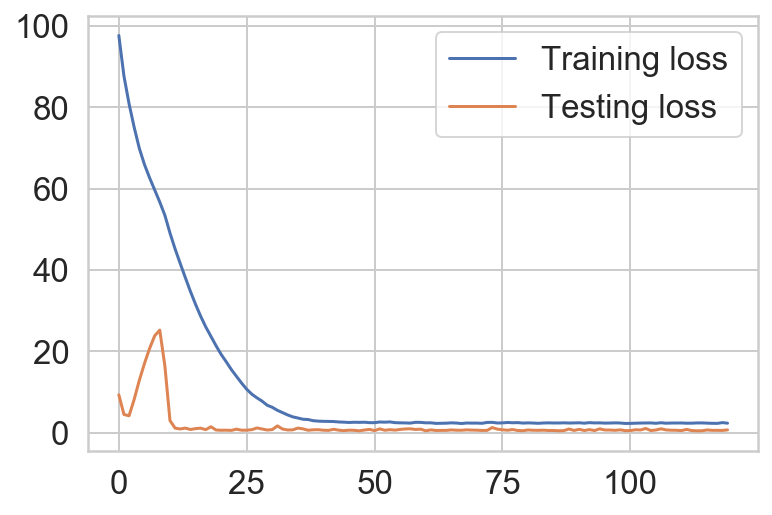

In [29]:
train_loss = nn_history.history['loss']
test_loss = nn_history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

In [30]:
#Reshape from 3D array to 2D array to fit the other models 
X_train = LSTM_training_inputs.reshape((2490,30))
X_test = LSTM_test_inputs.reshape((222,30))

## ARIMA

In [31]:
y = Saudi_Ceramic_for_arima['Close'].resample('MS').mean()

In [32]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [33]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        except:
            continue
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1554.7566960523855
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1296.6572801923196
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1124.7548264025966
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1171.0828725144845
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1058.3423423238064
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:939.1819317875196
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:1138.3615199242531
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:966.1749103292337
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:834.824373196311
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1166.9682977844716
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1155.7636699265745
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:1001.3190009425132
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1068.4950465786749
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1054.0444931790196
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:934.4318088010477
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:1017.1331284538799
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:967.0181179049534
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:822.4894848071726

ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:583.1146869460742
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:746.4640863276743
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:666.3002549893774
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:551.2649951176697
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:698.1139245440205
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:700.0728716425108
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:675.2967473164576
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:663.5849247899906
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:645.3741897784935
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:585.1129768115442
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:621.0874973232727
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:619.5016107152
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:558.1788144449464
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:904.839490665453
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:809.0251816584484
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:722.7804288241321
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:907.7089197258404
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:745.0395545985874
ARIMA(0, 2, 0)

ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:682.7412335952508
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:856.9416155722333
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:706.9603575700485
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:632.7670801065146
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:884.7688008390769
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:702.3106663025474
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:603.3595367140181
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:774.9041729268283
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:764.4573042492905
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:684.167682399851
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:747.4559590238306
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:708.9603579687686
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:628.2534708717194
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:745.8975322142458
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:686.2845659734218
ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:574.8805371421314
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:696.5319885833205
ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:698.1099149657858
ARIMA(1, 0,

ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:555.0921862942608
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:687.3820263106019
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:689.3420465255392
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:677.104734023575
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:653.1073191741395
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:634.8386883623684
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:600.1811136239537
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:606.2919077712216
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:604.9173519895363
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:556.8814307727237
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:840.7466653100373
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:751.5158426696008
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:673.2731915040243
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:850.1023028650271
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:702.3882384127583
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:590.559095346492
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:872.1823939572704
ARIMA(1, 2, 2)x(0, 2, 1, 12)12 - AIC:683.8635438597335
ARIMA(1, 2, 

ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:628.9933674730313
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:882.3225163854735
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:701.6378640059352
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:578.9878567076923
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:763.6096397756164
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:765.0144319311082
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:687.4506400150094
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:735.1948830249298
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:708.1116440436334
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:627.2233714972539
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:729.3666840341717
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:687.4506017657052
ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - AIC:580.9877639390552
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:685.6924906781971
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:687.4047780316928
ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:684.4235947850992
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:648.7923341325525
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:631.3115631372706
ARIMA(2, 1

In [34]:
#ARIMA(0, 1, 2)x(0, 2, 2, 12)12 - AIC:390.88788508639425

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0,1,2),
                                seasonal_order=(0,2,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4417      0.067      6.590      0.000       0.310       0.573
ma.L2          0.0646      0.108      0.600      0.549      -0.146       0.276
ma.S.L12      -1.4724    2.3e+04   -6.4e-05      1.000   -4.51e+04    4.51e+04
ma.S.L24       0.4724   1.09e+04   4.35e-05      1.000   -2.13e+04    2.13e+04
sigma2        42.0738   9.68e+05   4.35e-05      1.000    -1.9e+06     1.9e+06


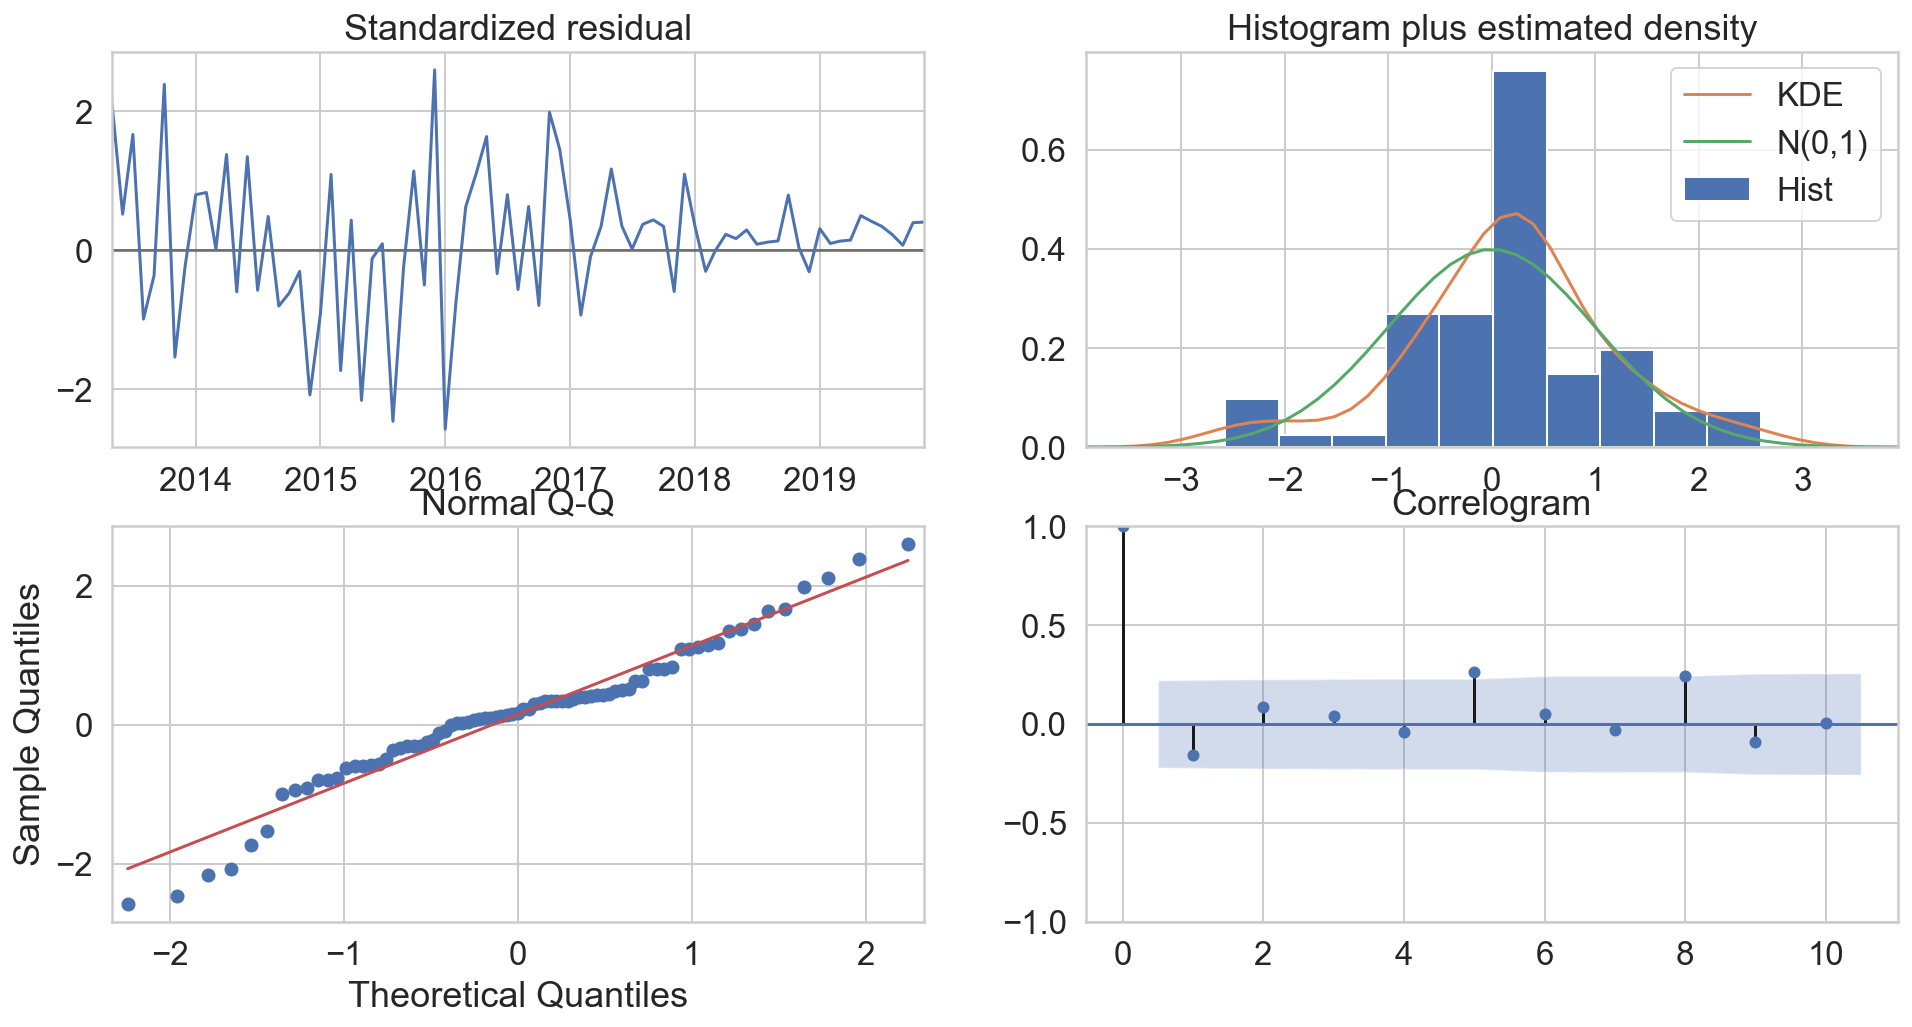

In [35]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

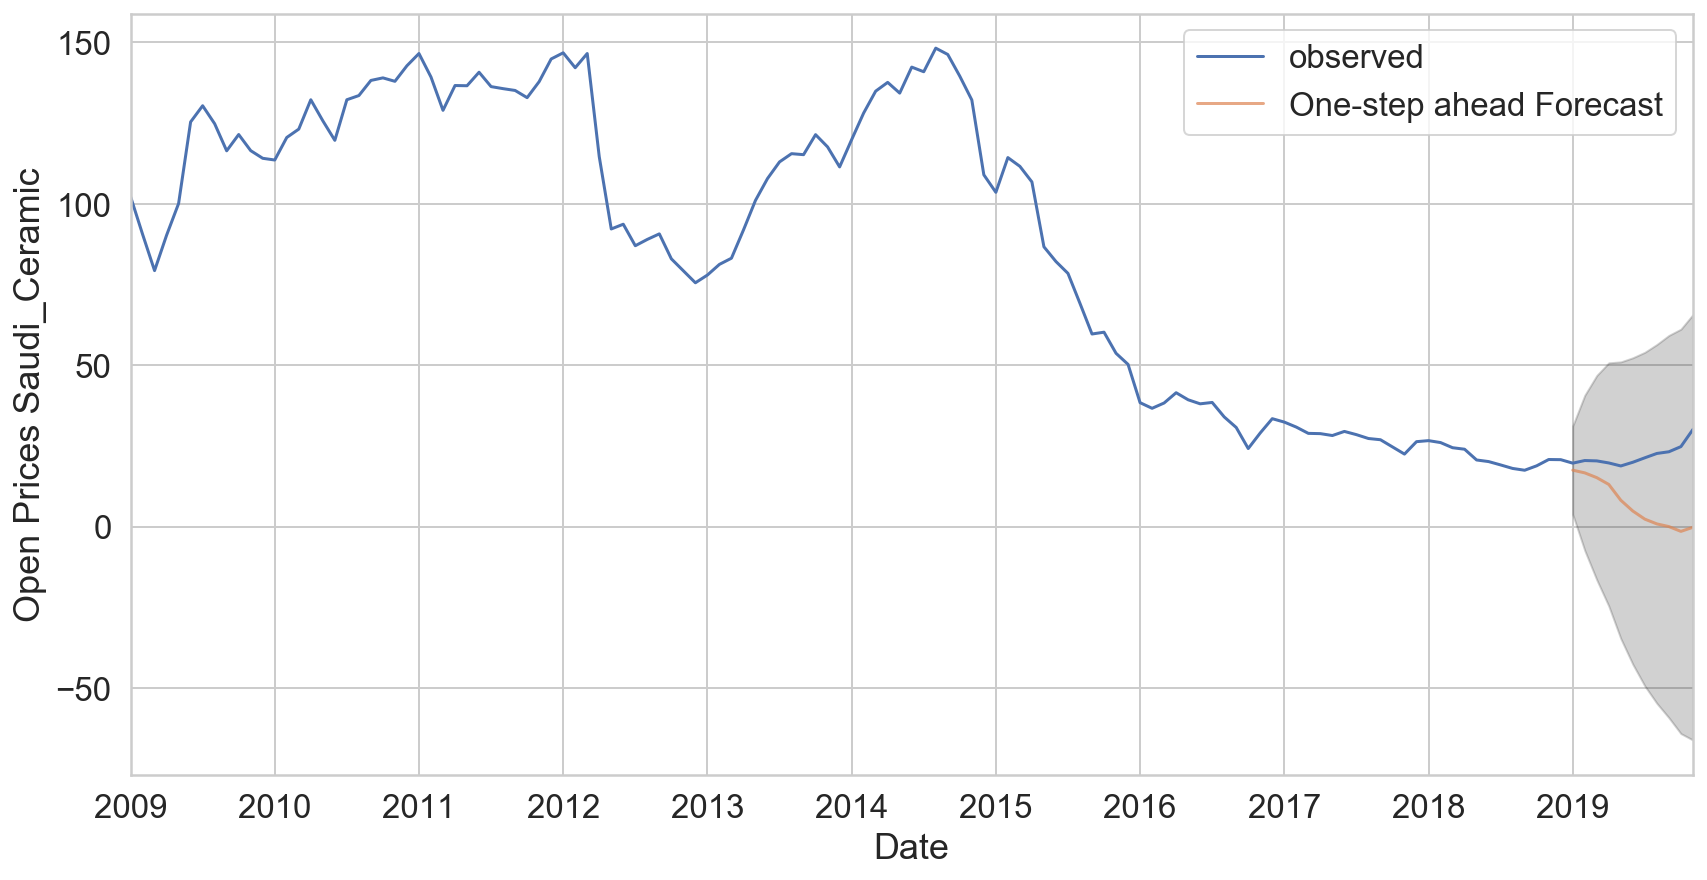

In [36]:
#Here i choose the start of 2019
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = y['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Open Prices Saudi_Ceramic')
plt.legend()
plt.show()

In [37]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 310.41


In [38]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 17.62


## Producing and visualizing forecasts

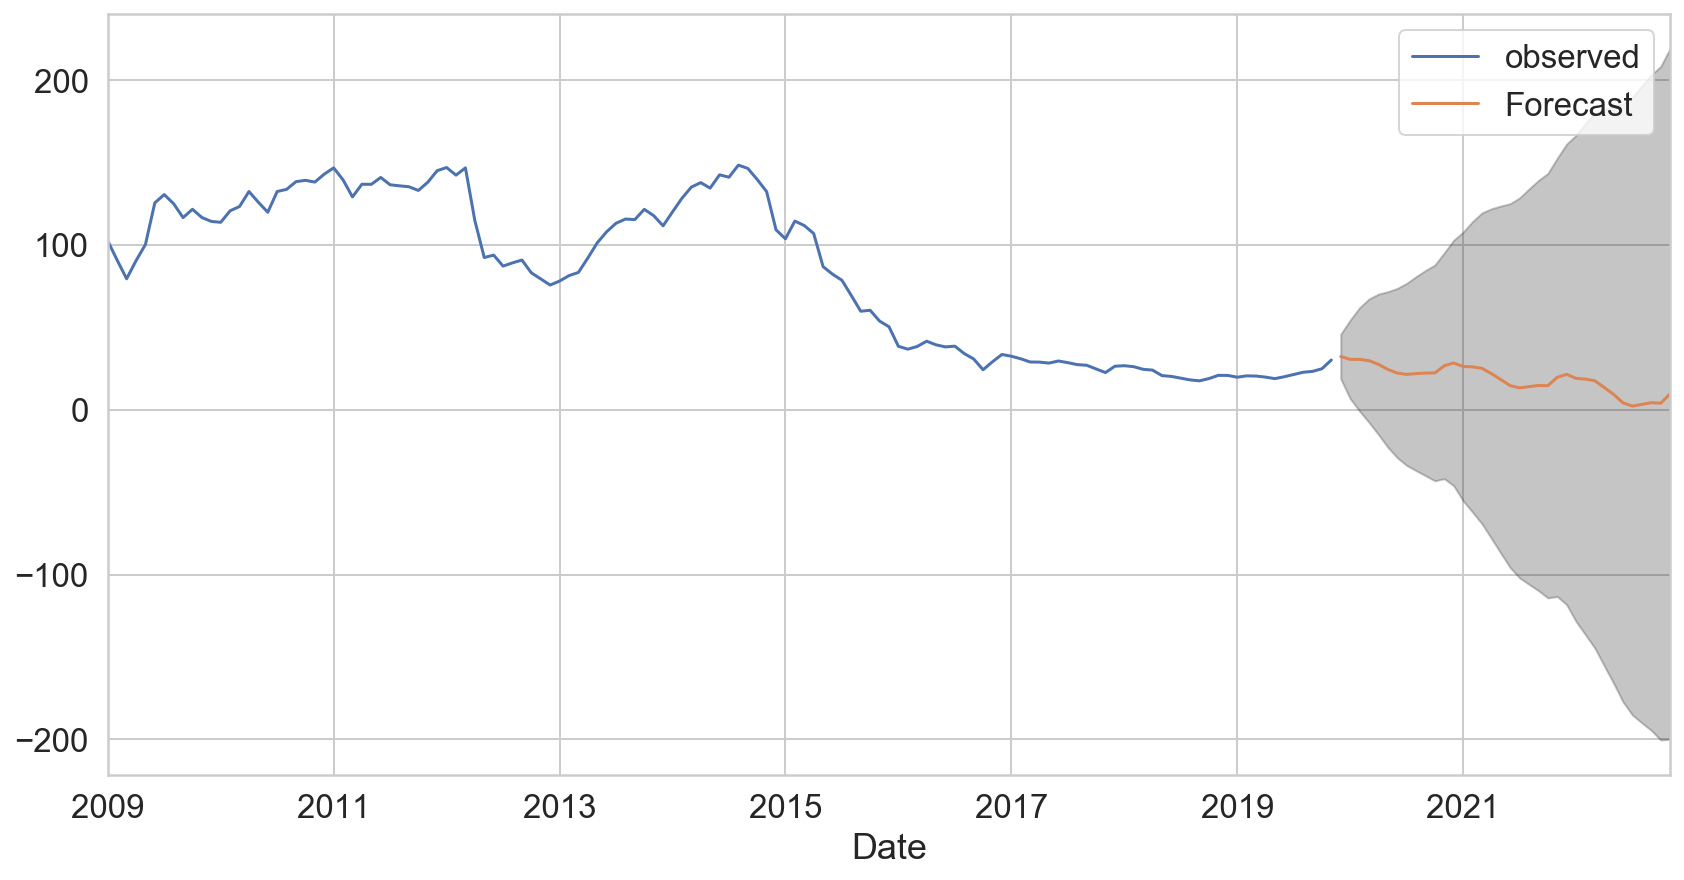

In [39]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
plt.legend()
plt.show()

## Model 

In [40]:
gboost  = GradientBoostingRegressor()
rt      = RandomForestRegressor()
lr      = LinearRegression()
lasso   = Lasso()
ridge   = Ridge()
en      = ElasticNet()
huber   = HuberRegressor()
lars    = Lars()

pa      = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
ranscac = RANSACRegressor()

mod = [lr, lasso, ridge, en, huber, lars, pa, ranscac, gboost, rt,# llars, sgd
      ]

In [41]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    model.predict(X_train)
    model.predict(X_test)


In [42]:
for i in mod:
     evaluate_model(i,X_train, LSTM_training_outputs, X_test, LSTM_test_outputs)

In [43]:
LSTM_pred = nn_model.predict(LSTM_test_inputs).T[0]

In [44]:
Lr_train_pred = lr.predict(X_train)
Lr_test_pred = lr.predict(X_test)
Lasso_train_pred = lasso.predict(X_train)
Lasso_test_pred = lasso.predict(X_test)
Ridge_train_pred = ridge.predict(X_train)
Ridge_test_pred = ridge.predict(X_test)
ElasticNet_train_pred = en.predict(X_train)
ElasticNet_test_pred = en.predict(X_test)
HuberRegressor_train_pred = huber.predict(X_train)
HuberRegressor_test_pred = huber.predict(X_test)
Lars_train_pred = lars.predict(X_train)
Lars_test_pred = lars.predict(X_test)

PassiveAggressiveRegressor_train_pred = pa.predict(X_train)
PassiveAggressiveRegressor_test_pred = pa.predict(X_test)
RANSACRegressor_train_pred = ranscac.predict(X_train)
RANSACRegressor_test_pred = ranscac.predict(X_test)

GradientBoostingRegressor_train_pred = gboost.predict(X_train)
GradientBoostingRegressor_test_pred = gboost.predict(X_test)
RandomForestRegressor_train_pred  = rt.predict(X_train)
RandomForestRegressor_test_pred  = rt.predict(X_test)

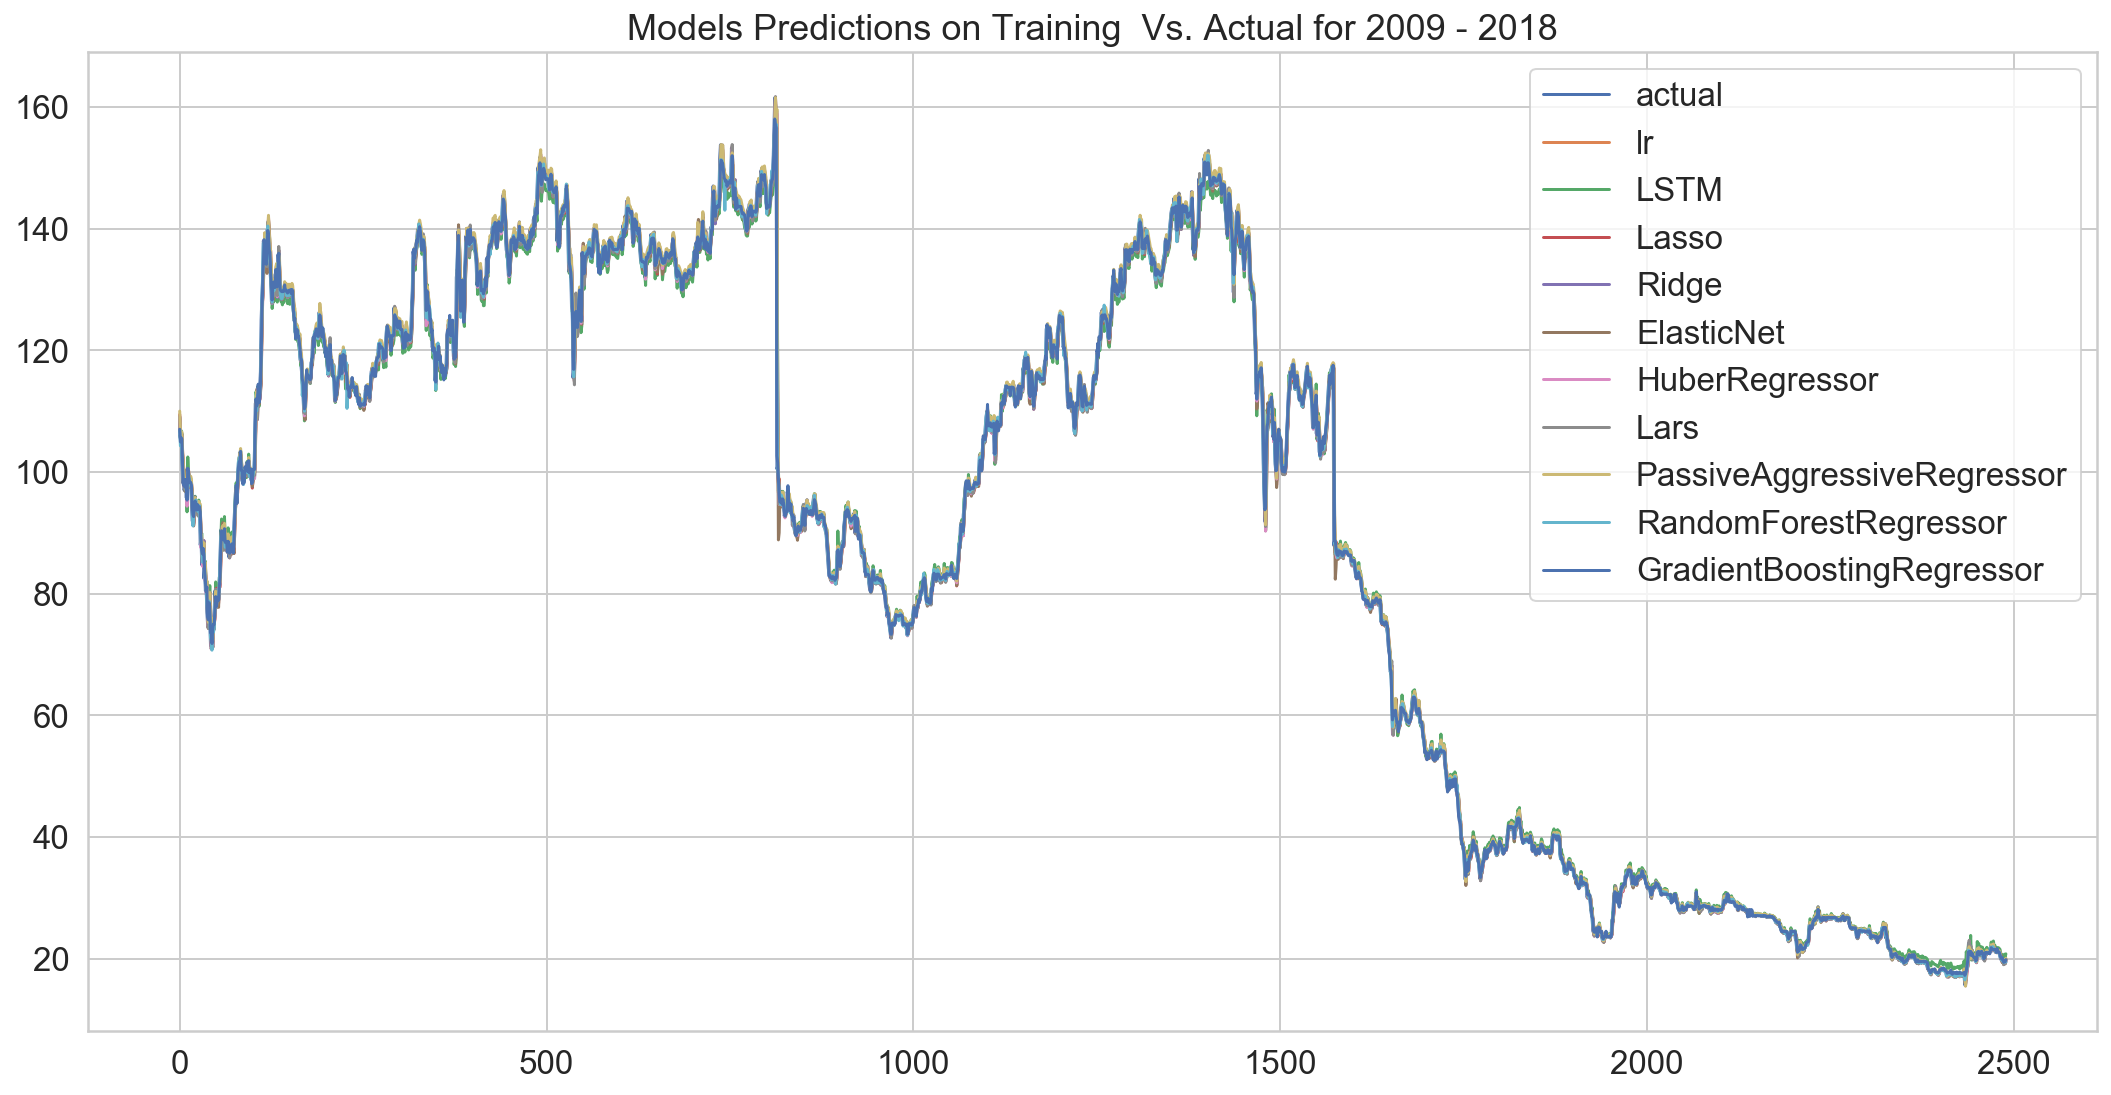

In [45]:
fig = plt.subplots( figsize=(18,9))
plt.plot(LSTM_training_outputs, label = "actual")
plt.plot(Lr_train_pred, label = "lr")
plt.plot(nn_model.predict(LSTM_training_inputs), label = "LSTM")
plt.plot(Lasso_train_pred, label = "Lasso")
plt.plot(Ridge_train_pred, label = "Ridge")
plt.plot(ElasticNet_train_pred, label = "ElasticNet")
plt.plot(HuberRegressor_train_pred, label = "HuberRegressor")
plt.plot(Lars_train_pred, label = "Lars")
# 
plt.plot(PassiveAggressiveRegressor_train_pred, label = "PassiveAggressiveRegressor")
plt.plot(RandomForestRegressor_train_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_train_pred, label = "GradientBoostingRegressor")
# plt.plot(RANSACRegressor_tradin_pred, label = "RANSACRegressor")

plt.title('Models Predictions on Training  Vs. Actual for 2009 - 2018')
plt.legend()
plt.show()

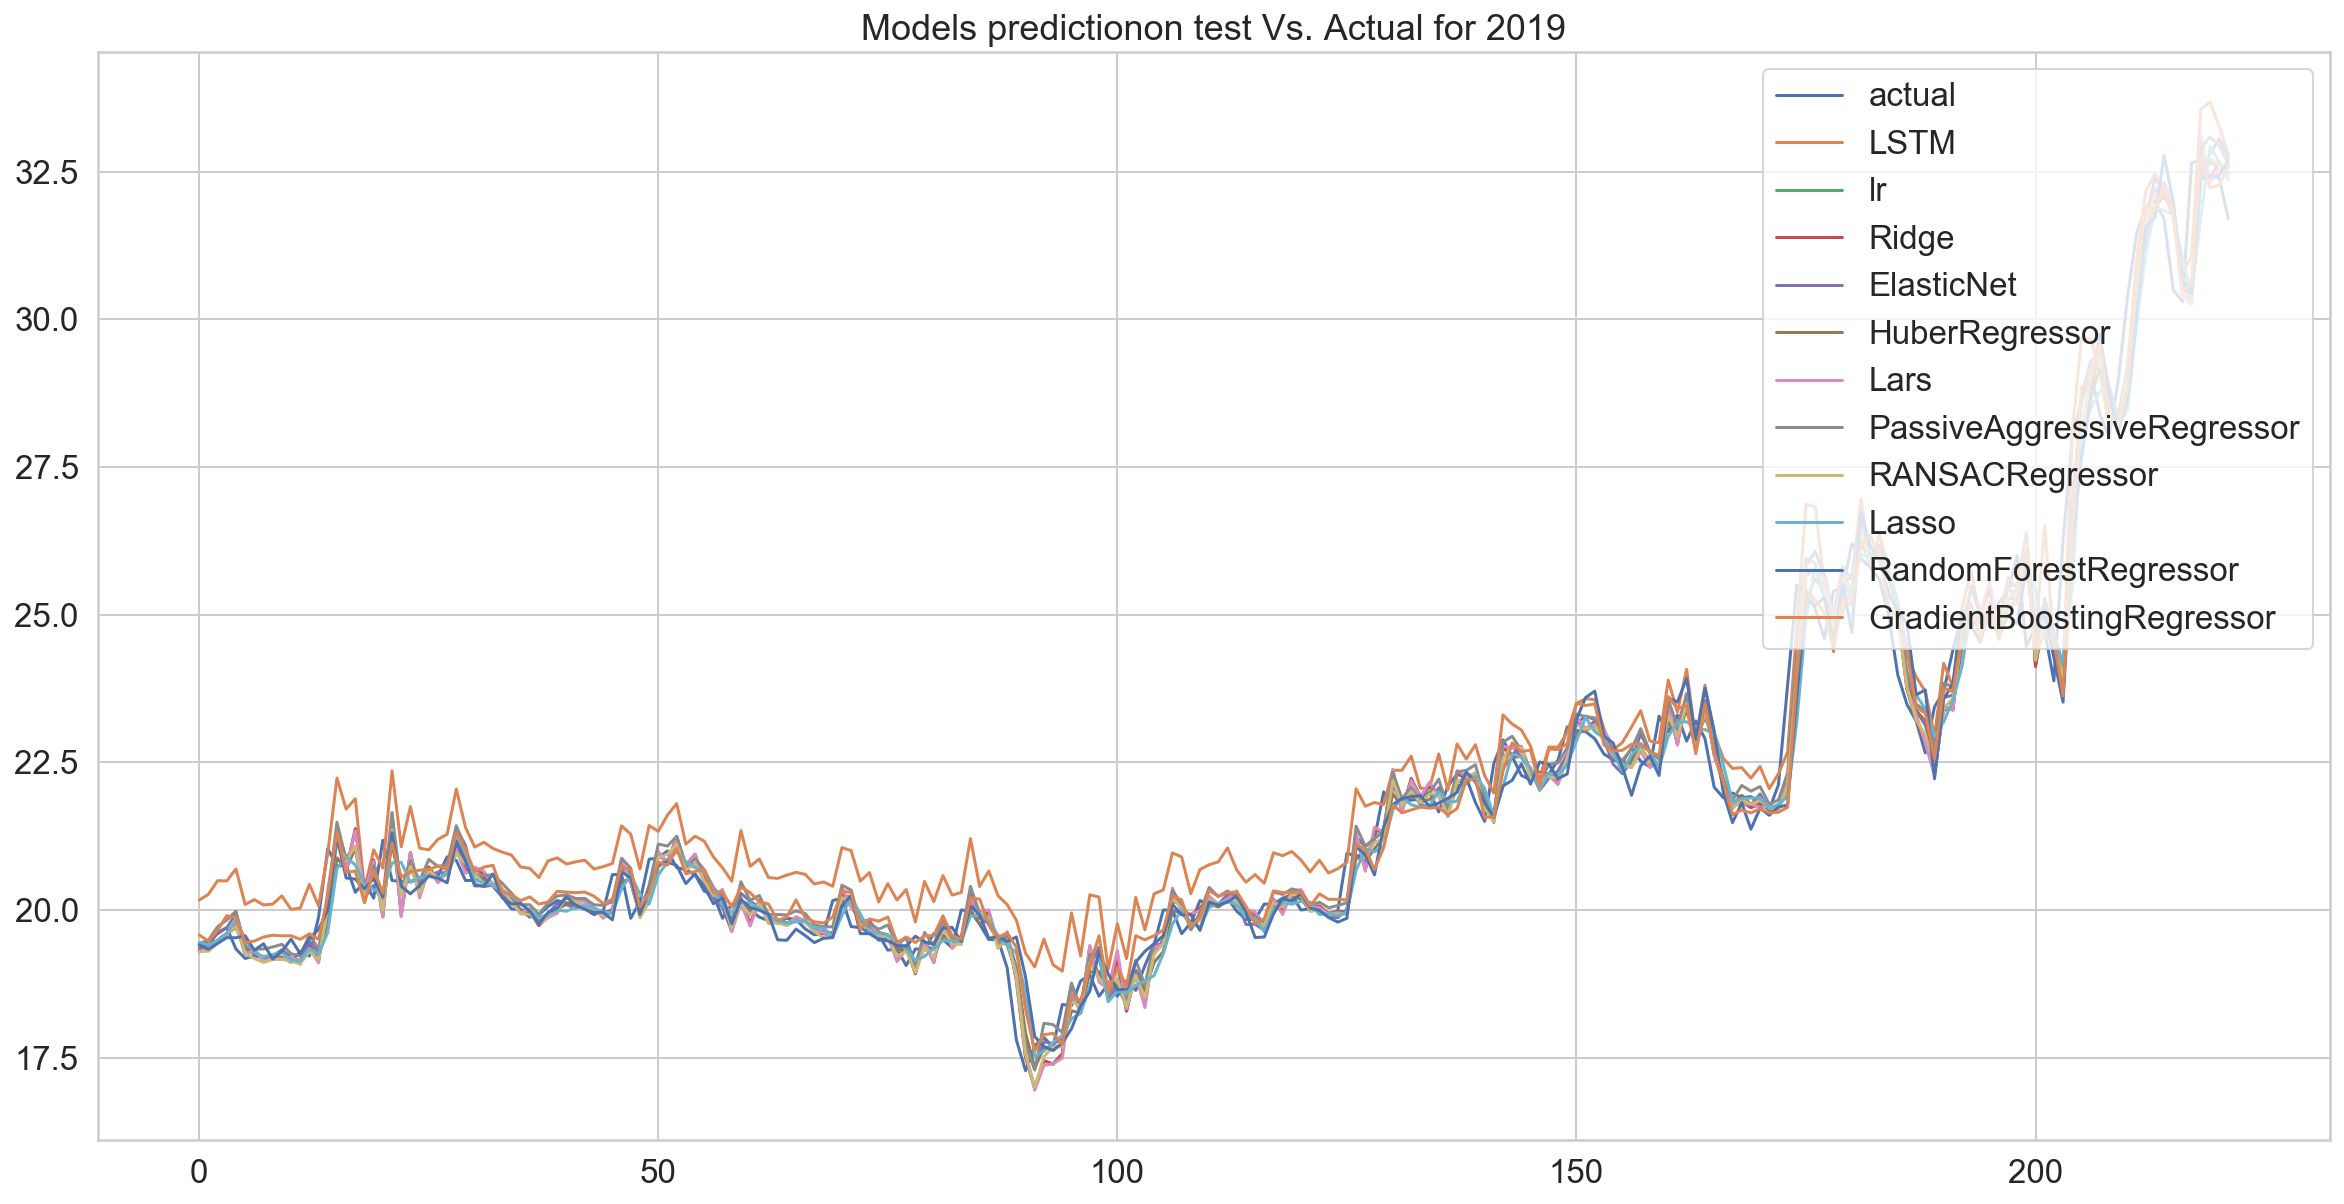

In [46]:
fig = plt.subplots( figsize=(20,10))
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "LSTM")
plt.plot(Lr_test_pred, label = "lr")
plt.plot(Ridge_test_pred, label = "Ridge")
plt.plot(ElasticNet_test_pred, label = "ElasticNet")
plt.plot(HuberRegressor_test_pred, label = "HuberRegressor")
plt.plot(Lars_test_pred, label = "Lars")

plt.plot(PassiveAggressiveRegressor_test_pred, label = "PassiveAggressiveRegressor")
plt.plot(RANSACRegressor_test_pred, label = "RANSACRegressor")

plt.plot(Lasso_test_pred, label = "Lasso")
plt.plot(RandomForestRegressor_test_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_test_pred, label = "GradientBoostingRegressor")
plt.title('Models predictionon test Vs. Actual for 2019')
plt.legend(loc=1)
plt.show()

In [47]:
predictions_test = pd.DataFrame({'Actual' : LSTM_test_outputs,
                                'Lr' : Lr_test_pred,
                                'Lasso' :Lasso_test_pred  ,
                                'Ridge':Ridge_test_pred ,
                                'ElasticNet' :ElasticNet_test_pred ,
                                'PassiveAggressiveRegressor' :PassiveAggressiveRegressor_test_pred  ,
                                'HuberRegressor': HuberRegressor_test_pred,
                                'Lars' : Lars_test_pred,
                                'RANSACRegressor' : RANSACRegressor_test_pred ,
                                'LSTM':LSTM_pred,
                                'GradientBoostingRegressor':GradientBoostingRegressor_test_pred,
                                'RandomForestRegressor':RandomForestRegressor_test_pred
                                }, 
                                columns=['Actual','Lr','Lasso', 'Ridge','ElasticNet','PassiveAggressiveRegressor',
                                        'HuberRegressor','Lars','RANSACRegressor','LSTM',  'RandomForestRegressor',
                                       'GradientBoostingRegressor' ])

In [48]:
predictions_test.head()

,Actual,Lr,Lasso,Ridge,ElasticNet,PassiveAggressiveRegressor,HuberRegressor,Lars,RANSACRegressor,LSTM,RandomForestRegressor,GradientBoostingRegressor
0,19.30,19.314897,19.446908,19.315095,19.378123,19.433553,19.370450,19.286178,19.299854,20.168268,19.410,19.576476
1,19.48,19.380902,19.409025,19.381060,19.378289,19.488999,19.371118,19.364459,19.300552,20.265055,19.336,19.473005
2,19.60,19.483740,19.480277,19.483935,19.624295,19.716602,19.472274,19.456924,19.439485,20.496355,19.434,19.659564
3,19.70,19.607159,19.597618,19.607288,19.698803,19.830532,19.600076,19.575875,19.606011,20.491640,19.532,19.902872
4,19.34,19.777031,19.837299,19.777069,19.937631,19.979485,19.702879,19.824290,19.719994,20.695091,19.530,19.870720


## Validating our model

In [49]:
df_new = pd.read_csv('NEWW-Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [50]:
df_new.Date = pd.to_datetime(df.Date, dayfirst=True)

In [51]:
df_new.sort_values('Date',inplace=True)

In [52]:
df_new.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
2121,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-03,17.06,17.06,16.78,16.90,-0.26,-1.52,147529,2494172.96,325
2123,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-04,17.38,17.38,17.18,17.18,-0.20,-1.15,142735,2465908.84,205
2133,Insurance,8290,Solidarity Saudi Takaful Co.,2009-01-05,10.32,10.36,10.30,10.34,-0.02,-0.19,47405,489919.30,106
2118,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-06,17.42,17.54,17.40,17.50,0.00,0.00,117410,2049337.42,222


In [53]:
Saudi_Ceramic_2_weeks = df_new[df_new['Company Name']== 'Saudi Ceramic Co.']

In [54]:
Saudi_Ceramic_2_weeks

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
365,Capital Goods,2040,Saudi Ceramic Co.,2018-03-27,30.40,31.70,30.00,31.35,0.95,3.13,574653,17768052.25,1563
363,Capital Goods,2040,Saudi Ceramic Co.,2018-03-29,31.40,31.90,30.85,31.20,-0.15,-0.48,258077,8078798.25,590
364,Capital Goods,2040,Saudi Ceramic Co.,2018-04-01,30.85,31.00,30.30,30.40,-0.60,-1.94,295414,9044302.65,809
372,Capital Goods,2040,Saudi Ceramic Co.,2018-04-09,31.00,31.95,30.55,31.65,0.45,1.44,517399,16279989.10,660
373,Capital Goods,2040,Saudi Ceramic Co.,2018-04-10,34.00,35.30,33.70,34.70,0.80,2.36,679446,23514524.10,1175
369,Capital Goods,2040,Saudi Ceramic Co.,2018-04-11,33.15,34.25,32.50,33.90,0.75,2.26,474212,15863857.15,801
370,Capital Goods,2040,Saudi Ceramic Co.,2018-04-12,31.80,33.35,31.50,32.65,1.05,3.32,690516,22485941.95,1155
371,Capital Goods,2040,Saudi Ceramic Co.,2018-04-15,32.95,33.35,32.60,33.15,0.50,1.53,320733,10603816.05,518
367,Capital Goods,2040,Saudi Ceramic Co.,2018-04-16,31.50,31.60,30.90,31.00,-0.50,-1.59,197282,6158204.70,474
368,Capital Goods,2040,Saudi Ceramic Co.,2018-04-17,31.60,31.95,31.50,31.60,-0.05,-0.16,372607,11783020.35,556


In [55]:
Saudi_Ceramic2w_for_model = Saudi_Ceramic_2_weeks[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [56]:
Saudi_Ceramic2w_for_model

,Date,Open,High,Low,Close,Change,% Change
365,2018-03-27,30.40,31.70,30.00,31.35,0.95,3.13
363,2018-03-29,31.40,31.90,30.85,31.20,-0.15,-0.48
364,2018-04-01,30.85,31.00,30.30,30.40,-0.60,-1.94
372,2018-04-09,31.00,31.95,30.55,31.65,0.45,1.44
373,2018-04-10,34.00,35.30,33.70,34.70,0.80,2.36
369,2018-04-11,33.15,34.25,32.50,33.90,0.75,2.26
370,2018-04-12,31.80,33.35,31.50,32.65,1.05,3.32
371,2018-04-15,32.95,33.35,32.60,33.15,0.50,1.53
367,2018-04-16,31.50,31.60,30.90,31.00,-0.50,-1.59
368,2018-04-17,31.60,31.95,31.50,31.60,-0.05,-0.16


In [57]:
Saudi_Ceramic2w_for_model.reset_index(inplace=True)

In [58]:
asm = Saudi_Ceramic_for_model[-6:]

In [59]:
asm

,index,Date,Open,High,Low,Close,Change,% Change
2716,76861,2019-11-21,30.50,31.10,29.85,30.30,-0.20,-0.66
2717,76862,2019-11-24,30.55,32.85,30.15,32.65,2.35,7.76
2718,76860,2019-11-25,32.70,34.40,32.10,32.70,0.05,0.15
2719,76858,2019-11-26,32.70,33.50,32.00,32.40,-0.30,-0.92
2720,76859,2019-11-27,32.50,33.30,32.20,32.40,0.00,0.00
2721,76857,2019-11-28,32.20,32.50,31.55,31.70,-0.70,-2.16


In [60]:
Saudi_Ceramic2w_for_model

,index,Date,Open,High,Low,Close,Change,% Change
0,365,2018-03-27,30.40,31.70,30.00,31.35,0.95,3.13
1,363,2018-03-29,31.40,31.90,30.85,31.20,-0.15,-0.48
2,364,2018-04-01,30.85,31.00,30.30,30.40,-0.60,-1.94
3,372,2018-04-09,31.00,31.95,30.55,31.65,0.45,1.44
4,373,2018-04-10,34.00,35.30,33.70,34.70,0.80,2.36
5,369,2018-04-11,33.15,34.25,32.50,33.90,0.75,2.26
6,370,2018-04-12,31.80,33.35,31.50,32.65,1.05,3.32
7,371,2018-04-15,32.95,33.35,32.60,33.15,0.50,1.53
8,367,2018-04-16,31.50,31.60,30.90,31.00,-0.50,-1.59
9,368,2018-04-17,31.60,31.95,31.50,31.60,-0.05,-0.16


In [61]:
abr = asm.merge(Saudi_Ceramic2w_for_model, how='outer')

In [62]:
abr.set_index('Date',inplace=True)

In [63]:
abr.pop('index')

Date
2019-11-21    76861
2019-11-24    76862
2019-11-25    76860
2019-11-26    76858
2019-11-27    76859
2019-11-28    76857
2018-03-27      365
2018-03-29      363
2018-04-01      364
2018-04-09      372
2018-04-10      373
2018-04-11      369
2018-04-12      370
2018-04-15      371
2018-04-16      367
2018-04-17      368
2018-04-22      366
Name: index, dtype: int64

In [64]:
abr

,Open,High,Low,Close,Change,% Change
Date,,,,,,
2019-11-21,30.50,31.10,29.85,30.30,-0.20,-0.66
2019-11-24,30.55,32.85,30.15,32.65,2.35,7.76
2019-11-25,32.70,34.40,32.10,32.70,0.05,0.15
2019-11-26,32.70,33.50,32.00,32.40,-0.30,-0.92
2019-11-27,32.50,33.30,32.20,32.40,0.00,0.00
2019-11-28,32.20,32.50,31.55,31.70,-0.70,-2.16
2018-03-27,30.40,31.70,30.00,31.35,0.95,3.13
2018-03-29,31.40,31.90,30.85,31.20,-0.15,-0.48
2018-04-01,30.85,31.00,30.30,30.40,-0.60,-1.94


In [65]:
abr2=abr[1:].values

In [66]:
abr2

array([[30.55, 32.85, 30.15, 32.65,  2.35,  7.76],
       [32.7 , 34.4 , 32.1 , 32.7 ,  0.05,  0.15],
       [32.7 , 33.5 , 32.  , 32.4 , -0.3 , -0.92],
       [32.5 , 33.3 , 32.2 , 32.4 ,  0.  ,  0.  ],
       [32.2 , 32.5 , 31.55, 31.7 , -0.7 , -2.16],
       [30.4 , 31.7 , 30.  , 31.35,  0.95,  3.13],
       [31.4 , 31.9 , 30.85, 31.2 , -0.15, -0.48],
       [30.85, 31.  , 30.3 , 30.4 , -0.6 , -1.94],
       [31.  , 31.95, 30.55, 31.65,  0.45,  1.44],
       [34.  , 35.3 , 33.7 , 34.7 ,  0.8 ,  2.36],
       [33.15, 34.25, 32.5 , 33.9 ,  0.75,  2.26],
       [31.8 , 33.35, 31.5 , 32.65,  1.05,  3.32],
       [32.95, 33.35, 32.6 , 33.15,  0.5 ,  1.53],
       [31.5 , 31.6 , 30.9 , 31.  , -0.5 , -1.59],
       [31.6 , 31.95, 31.5 , 31.6 , -0.05, -0.16],
       [31.65, 32.2 , 31.2 , 31.5 , -0.2 , -0.63]])

In [67]:
X_valid = []
for i in range(len(abr2)-window_len):
    temp_set = abr2[i:(i+window_len)].copy()
    X_valid.append(temp_set)
y_valid = abr['Close'][window_len:].values
X_valid = np.array(X_valid)

In [68]:
X_valid

array([[[30.55, 32.85, 30.15, 32.65,  2.35,  7.76],
        [32.7 , 34.4 , 32.1 , 32.7 ,  0.05,  0.15],
        [32.7 , 33.5 , 32.  , 32.4 , -0.3 , -0.92],
        [32.5 , 33.3 , 32.2 , 32.4 ,  0.  ,  0.  ],
        [32.2 , 32.5 , 31.55, 31.7 , -0.7 , -2.16]],

       [[32.7 , 34.4 , 32.1 , 32.7 ,  0.05,  0.15],
        [32.7 , 33.5 , 32.  , 32.4 , -0.3 , -0.92],
        [32.5 , 33.3 , 32.2 , 32.4 ,  0.  ,  0.  ],
        [32.2 , 32.5 , 31.55, 31.7 , -0.7 , -2.16],
        [30.4 , 31.7 , 30.  , 31.35,  0.95,  3.13]],

       [[32.7 , 33.5 , 32.  , 32.4 , -0.3 , -0.92],
        [32.5 , 33.3 , 32.2 , 32.4 ,  0.  ,  0.  ],
        [32.2 , 32.5 , 31.55, 31.7 , -0.7 , -2.16],
        [30.4 , 31.7 , 30.  , 31.35,  0.95,  3.13],
        [31.4 , 31.9 , 30.85, 31.2 , -0.15, -0.48]],

       [[32.5 , 33.3 , 32.2 , 32.4 ,  0.  ,  0.  ],
        [32.2 , 32.5 , 31.55, 31.7 , -0.7 , -2.16],
        [30.4 , 31.7 , 30.  , 31.35,  0.95,  3.13],
        [31.4 , 31.9 , 30.85, 31.2 , -0.15, -0.48],
      

In [69]:
X_valid_resaped = X_valid.reshape(11,30)

In [70]:
y_valid

array([31.7 , 31.35, 31.2 , 30.4 , 31.65, 34.7 , 33.9 , 32.65, 33.15,
       31.  , 31.6 , 31.5 ])

In [71]:
LSTM_valid_pred = nn_model.predict(X_valid).T[0]
Lr_valid_pred = lr.predict(X_valid_resaped)
Lasso_valid_pred = lasso.predict(X_valid_resaped)
Ridge_valid_pred = ridge.predict(X_valid_resaped)
ElasticNet_valid_pred = en.predict(X_valid_resaped)
HuberRegressor_valid_pred = huber.predict(X_valid_resaped)
Lars_valid_pred = lars.predict(X_valid_resaped)

PassiveAggressiveRegressor_valid_pred = pa.predict(X_valid_resaped)
RANSACRegressor_valid_pred = ranscac.predict(X_valid_resaped)

GradientBoostingRegressor_valid_pred = gboost.predict(X_valid_resaped)
RandomForestRegressor_valid_pred  = rt.predict(X_valid_resaped)

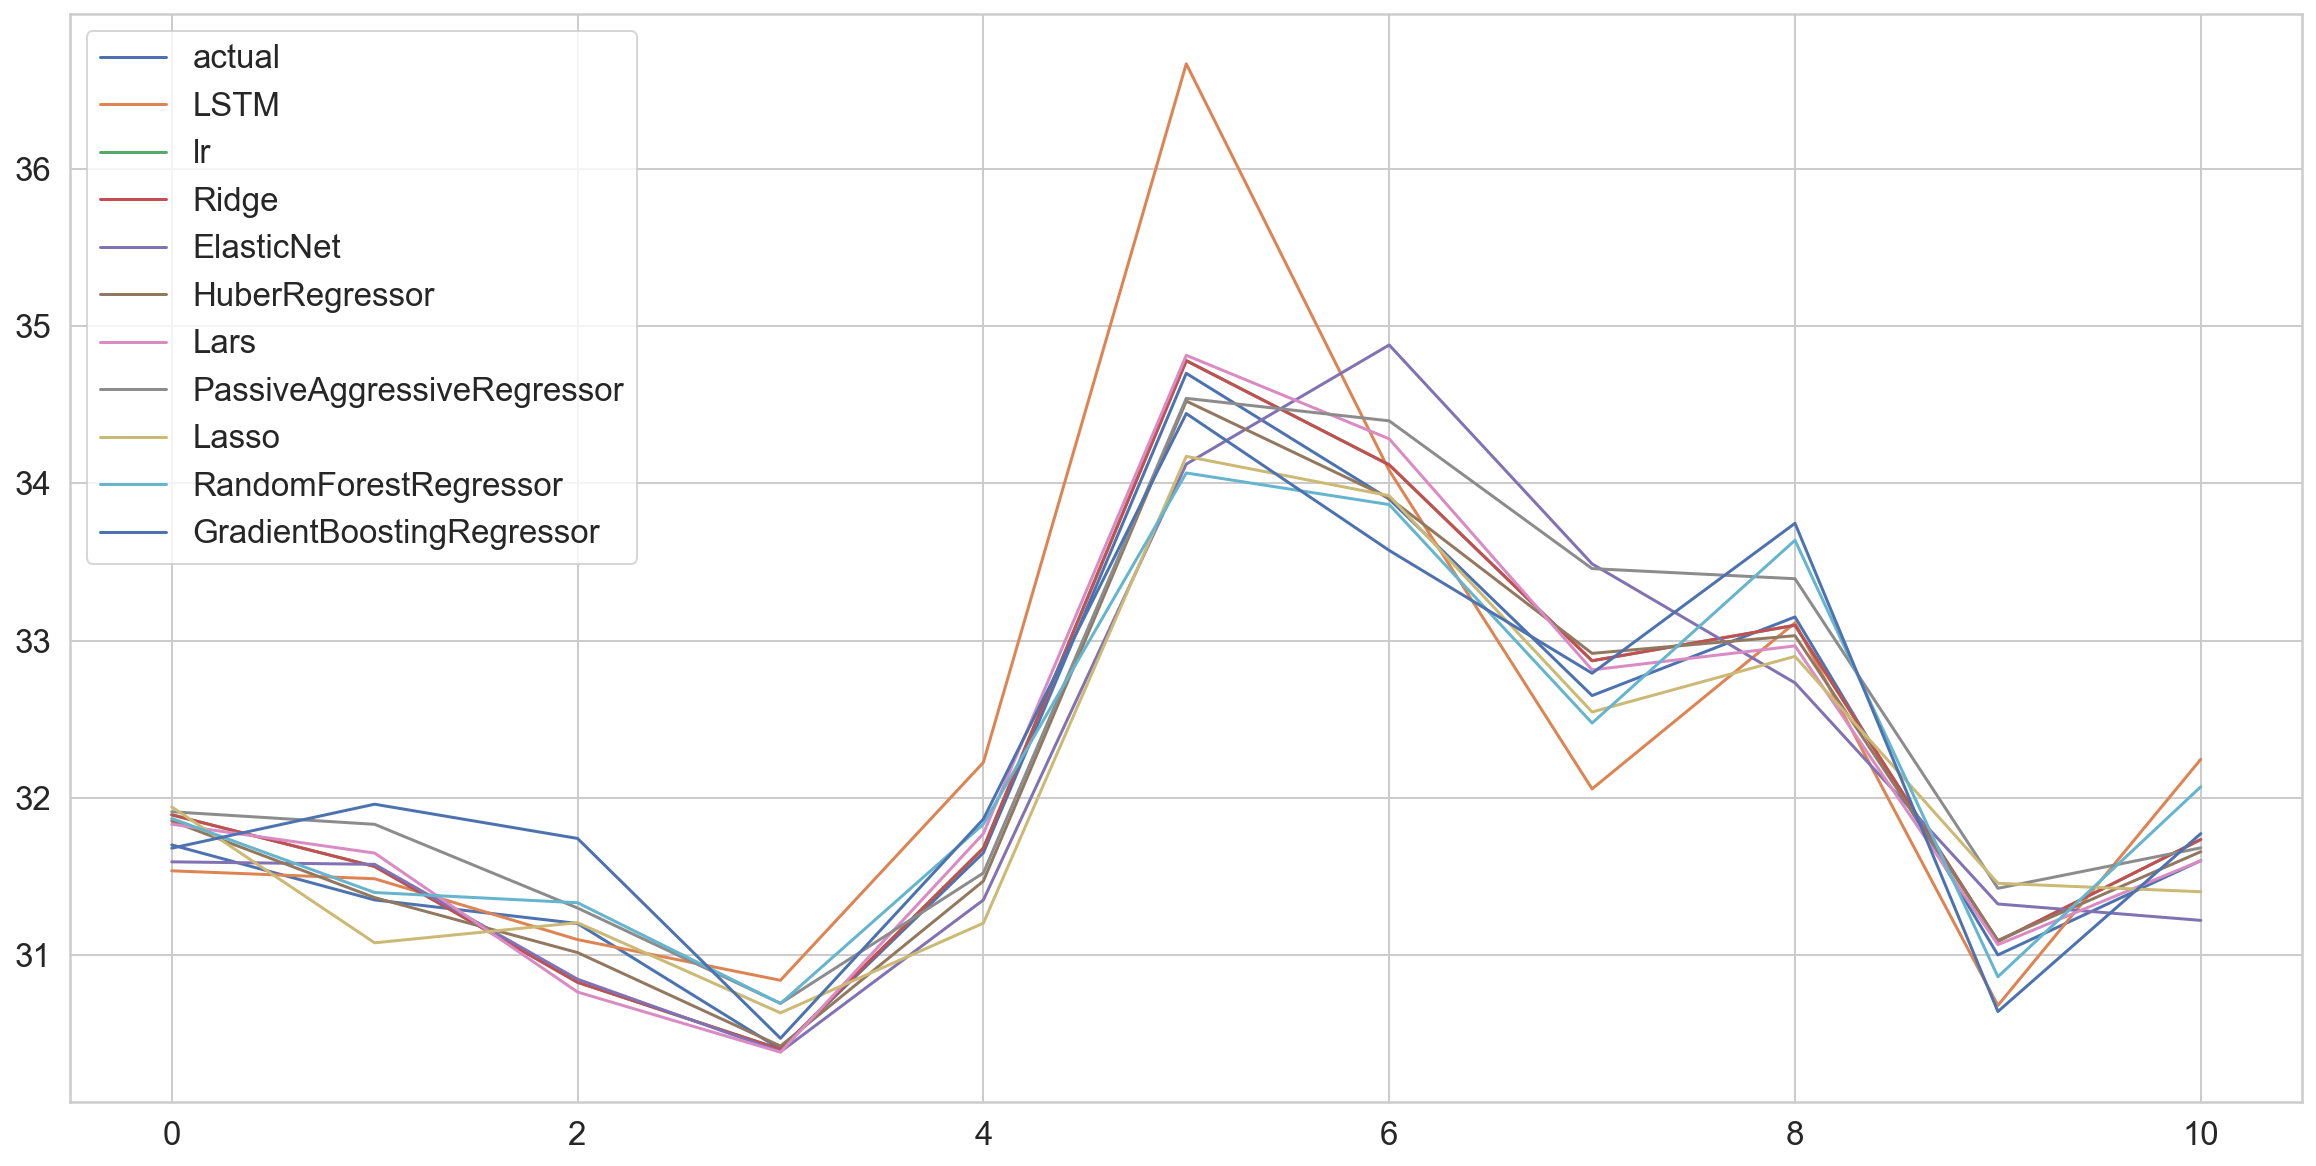

In [72]:
fig = plt.subplots( figsize=(20,10))
plt.plot(y_valid[:-1], label = "actual")
plt.plot(LSTM_valid_pred, label = "LSTM")
plt.plot(Lr_valid_pred, label = "lr")
plt.plot(Ridge_valid_pred, label = "Ridge")
plt.plot(ElasticNet_valid_pred, label = "ElasticNet")
plt.plot(HuberRegressor_valid_pred, label = "HuberRegressor")
plt.plot(Lars_valid_pred, label = "Lars")
# plt.plot(LassoLars_valid_pred, label = "LassoLars")
plt.plot(PassiveAggressiveRegressor_valid_pred, label = "PassiveAggressiveRegressor")
#plt.plot(RANSACRegressor_valid_pred, label = "RANSACRegressor")
# plt.plot(SGDRegressor_valid_pred, label = "SGDRegressor")
plt.plot(Lasso_valid_pred, label = "Lasso")
plt.plot(RandomForestRegressor_valid_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_valid_pred, label = "GradientBoostingRegressor")
plt.legend(loc=2)
plt.show()

In [73]:
R2_score_valid_LSTM = r2_score(y_valid[:-1],nn_model.predict(X_valid))

In [74]:
R2_traininig_score_LSTM = r2_score(LSTM_training_outputs,nn_model.predict(LSTM_training_inputs))

In [75]:
R2_score_test_LSTM=r2_score(LSTM_test_outputs,nn_model.predict(LSTM_test_inputs))

In [76]:
R2_score_test_LSTM

0.929647725030496

In [77]:
R2_traininig_score_LSTM

0.9977190504753729

In [78]:
R2_score_valid_LSTM

0.6934351183154808

In [79]:
models = ['LSTM','LR', 'lasso', 'ridge', 'en', 'huber', 'lars', 'pa', #'ranscac',
          'gboost', 'rt']
Training_R2=[R2_traininig_score_LSTM,lr.score(X_train,LSTM_training_outputs),
            lasso.score(X_train,LSTM_training_outputs),ridge.score(X_train,LSTM_training_outputs), 
            en.score(X_train,LSTM_training_outputs),huber.score(X_train,LSTM_training_outputs),
            lars.score(X_train,LSTM_training_outputs),
            pa.score(X_train,LSTM_training_outputs), #ranscac.score(X_train,LSTM_training_outputs),
             gboost.score(X_train,LSTM_training_outputs), rt.score(X_train,LSTM_training_outputs)]
Test_R2=[R2_score_test_LSTM,lr.score(X_test,LSTM_test_outputs),lasso.score(X_test,LSTM_test_outputs), 
         ridge.score(X_test,LSTM_test_outputs),en.score(X_test,LSTM_test_outputs), 
         huber.score(X_test,LSTM_test_outputs),lars.score(X_test,LSTM_test_outputs), 
         pa.score(X_test,LSTM_test_outputs), 
        # ranscac.score(X_test,LSTM_test_outputs), 
         gboost.score(X_test,LSTM_test_outputs),rt.score(X_test,LSTM_test_outputs)]
valid_R2=[R2_score_valid_LSTM,lr.score(X_valid_resaped, y_valid[:-1]),lasso.score(X_valid_resaped, y_valid[:-1]), 
         ridge.score(X_valid_resaped, y_valid[:-1]),en.score(X_valid_resaped, y_valid[:-1]), 
         huber.score(X_valid_resaped, y_valid[:-1]),lars.score(X_valid_resaped, y_valid[:-1]), 
         pa.score(X_valid_resaped, y_valid[:-1]), 
         #ranscac.score(X_valid_resaped, y_valid[:-1]), 
         gboost.score(X_valid_resaped, y_valid[:-1]),rt.score(X_valid_resaped, y_valid[:-1])]

In [80]:
R2_scores = pd.DataFrame({'models' : models,
                                'Training_R2' : Training_R2,
                                'Test_R2' :Test_R2  ,
                                'valid_R2':valid_R2 ,
                                }, 
                                columns=[ 'models','Training_R2','Test_R2','valid_R2'])

In [81]:
R2_scores

,models,Training_R2,Test_R2,valid_R2
0,LSTM,0.997719,0.929648,0.693435
1,LR,0.998024,0.973166,0.979744
2,lasso,0.997687,0.969249,0.943523
3,ridge,0.998024,0.973176,0.979778
4,en,0.997659,0.974239,0.845554
5,huber,0.997975,0.974612,0.987439
6,lars,0.998008,0.972704,0.969350
7,pa,0.997638,0.975387,0.910918
8,gboost,0.999120,0.971920,0.918726
9,rt,0.999595,0.965794,0.938362


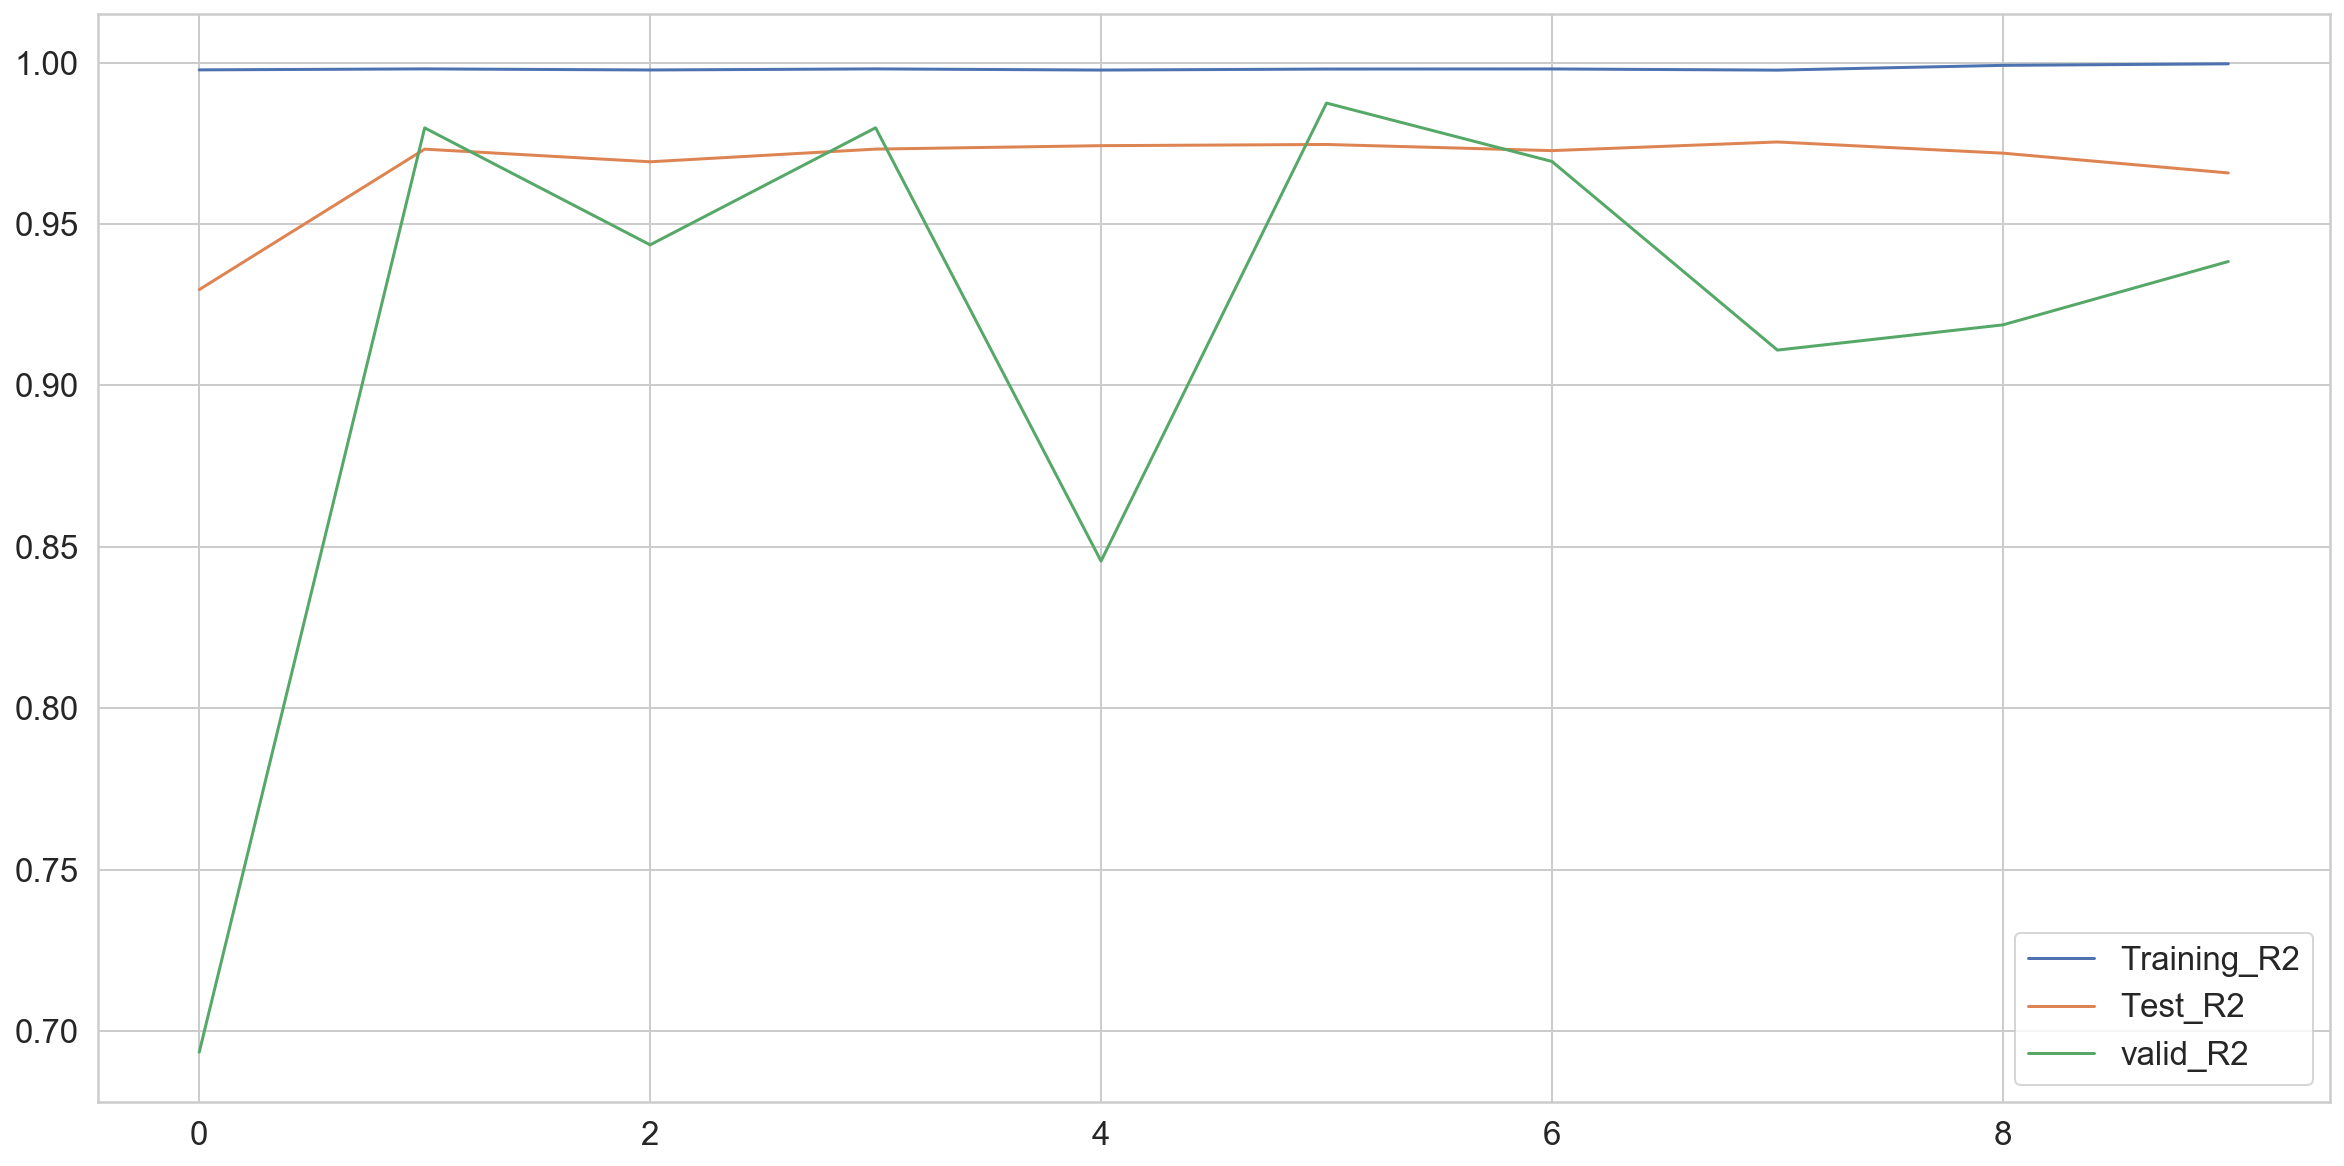

In [82]:
fig = plt.subplots( figsize=(20,10))
plt.plot(R2_scores['Training_R2'] ,label = "Training_R2")
plt.plot(R2_scores['Test_R2'] ,label = "Test_R2")
plt.plot(R2_scores['valid_R2'] ,label = "valid_R2")
xlabel=R2_scores['models']
plt.legend()
plt.show()